### Dataloader 


In this script we will perform a LSTM neural network on the CiteULike dataset. 

In [1]:
#!pip install torchtext

In [2]:
from torchtext.data import Dataset, BucketIterator, Field, TabularDataset, Iterator
from torchtext.vocab import Vocab
import pandas as pd
import numpy as np
import spacy

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch import nn
import torch.nn.utils.rnn as rnn_utils

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

Defining our dataloader
Splitting the dataset up in a training, validation and test set. 

In [4]:
## Read datasets 
CiteULike_data=pd.read_csv('data/citeulike/raw-data.csv')
#Loading small dataset for speed 
User_info = pd.read_csv('data/citeulike/user-info-small.csv')


def zero_indexing(nparr):
    uniq = np.unique(nparr)
    name2idx = {o:i for i,o in enumerate(uniq)}
    return np.array([name2idx[o] for o in nparr]), uniq

User_info["user.id"], uniq = zero_indexing(User_info["user.id"].values)

User_info = User_info.sample(frac=1) # Shuffle
User_info["doc.id"] = [CiteULike_data.iloc[int(idx),1] for idx in User_info["doc.id"]]

max_length = max((len(s.split(' ')) for s in CiteULike_data.iloc[:,1]))


# split train, validation and test in respectively 70%,20% and 10% of the data size

n=len(User_info)
trn_len=int(n*0.7)
val_len=int(n*0.2)
test_len=n-trn_len-val_len


train = User_info[:trn_len]
val = User_info[trn_len:-test_len]
test = User_info[trn_len:-val_len]

#Defining unique coloumns and userId and removing the header 
uniq_items = np.unique(CiteULike_data["doc.id"])[:-1]
uniq_users = np.unique(train["user.id"])[:-1]
items = set((x[0],x[1]) for x in train[["user.id","doc.id"]].values)

pairs = []
i = 0
while(i < len(train)):
    
    item = np.random.choice(uniq_items, size = 1)[0]
    user = np.random.choice(uniq_users, size = 1)[0]
    if (user,item) not in items:
        i += 1
        pairs += [(user,item,0)]
        items.add((user,item))

        
        
User_info_Negatives = np.vstack((train, pairs))

train = pd.DataFrame(data = User_info_Negatives,columns = ["user.id","doc.id", "rating"])

val.to_csv('data/citeulike/val.csv', header = False, index = False)
test.to_csv('data/citeulike/test.csv', header = False, index = False)

del User_info_Negatives, items, uniq_items, uniq_users, pairs, User_info, val, test

for i,val in enumerate(train["doc.id"][n:]):
    train["doc.id"].loc[n+i] = CiteULike_data.iloc[int(val),1]

train = train.sample(frac=1) #shuffle panda style

train.to_csv('data/citeulike/train.csv', header = False, index = False)


Tokenizer: ID is the User_ID, Text: is the article's abstract and Label 

In [5]:
spacy_en = spacy.load('en')

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text)]

#text field is sequential data while label and ID is not. Setting Text data to lower case and setting the fixed length
#to the maximum length so all examples will be padded according to this.
#For Label and ID we set use_vocab=False because it is numerical. 
#include_lengths – Whether to return a tuple of a padded minibatch 
#and a list containing the lengths of each examples, or just a padded minibatch. Default: False.

TEXT = Field(sequential=True, lower=True, include_lengths=True, fix_length=max_length)
LABEL = Field(sequential=False, use_vocab=False)
ID = Field(sequential=False, use_vocab=False)

#Loading data
train, val, test = TabularDataset.splits(
        path='data/citeulike', train='train.csv',
        validation='val.csv', test='test.csv', format='csv',
        fields=[('ID', ID), ('Text', TEXT), ('Label', LABEL)])

#Building vocab
TEXT.build_vocab(train, vectors="glove.6B.100d")
LABEL.build_vocab(train)
ID.build_vocab(train)

In [6]:
print('Text fields:')
#print('keys of TEXT.vocab:', list(TEXT.vocab.__dict__.keys()))
print(' size of vocabulary:', len(TEXT.vocab))
print(" vocabulary's embedding dimension:", TEXT.vocab.vectors.size())
print(' no. times the "fun" appear in the dataset:', TEXT.vocab.freqs['fun'])

print('\nLabel fields:')
#print('keys of LABEL.vocab:', list(LABEL.vocab.__dict__.keys()))
print(" list of vocabulary (int-to-str):", LABEL.vocab.itos)
print(" list of vocabulary (str-to-int):", dict(LABEL.vocab.stoi))

Text fields:
 size of vocabulary: 5052
 vocabulary's embedding dimension: torch.Size([5052, 100])
 no. times the "fun" appear in the dataset: 0

Label fields:
 list of vocabulary (int-to-str): ['<unk>', '0', '1']
 list of vocabulary (str-to-int): {'<unk>': 0, '0': 1, '1': 2}


Choosing batchsize and defining the three iterators and setting sort_within_batch = True so the lengths in the bathsize are sorted in decreasing order. 

In [7]:
batch_size = (45, 45, 45)

train_iter, val_iter, test_iter = BucketIterator.splits(
    (train, val, test), batch_sizes=batch_size, sort_key=lambda x: len(x.Text), sort_within_batch = True)

### LSTM  - Building the model


In [8]:
#embedding_dim

In [9]:
# size of embeddings
TEXT_Shape = TEXT.vocab.vectors.size()
embedding_dim = TEXT_Shape[1]
#num_embeddings = TEXT.vocab.vectors.size()[0]
#num_classes = len(LABEL.vocab.itos)
num_users = len(ID.vocab.itos)
num_items = TEXT_Shape[0]

n_hidden = 104
l1_hidden = 105

class CFNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=embedding_dim, n_hidden=n_hidden, l1_hidden=l1_hidden):
        super(CFNN, self).__init__()
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)
        self.lin1 = nn.Linear(n_hidden+embedding_dim, l1_hidden)
        self.lin2 = nn.Linear(l1_hidden, 1)
        self.drop0 = nn.Dropout(0.1)
        self.drop1 = nn.Dropout(0.1)
                
        # RNN decoding
        self.rnn = nn.LSTM(embedding_dim, n_hidden, bidirectional = True)
        self.rnnlin = nn.Linear(n_hidden*3, n_hidden)
        
        self.sigmoid = nn.Sigmoid()
        
        ## Attention module
        self.attn = nn.Linear(n_hidden*2, n_hidden)
        
    def forward(self, u, v, hidden, seq_lengths):
        #print(v.shape)
        U = self.user_emb(u)
        V = self.item_emb(v)
                
        ## Packing, Encoding, Padding
        packed = rnn_utils.pack_padded_sequence(V, seq_lengths)
        rnnOut, (hn, cn) = self.rnn(packed, hidden)
        padded, seq_lengths = rnn_utils.pad_packed_sequence(rnnOut, padding_value=0, total_length=max_length)
        seq_lengths = seq_lengths.float()
        
        # Divide each batch_element by sequence_element and sum. (mean by seq_length)
        padded = (padded.transpose(1,2) / seq_lengths).transpose(1,2)
        mean = padded.sum(dim=0)
        
        V_rnn = torch.cat([mean, hn[-1]], dim=1)
        V_rnn = F.relu(self.rnnlin(V_rnn))
                 
        x = torch.cat([U, V_rnn], dim=1)

        ## Classification
        x = self.drop0(x)
        x = F.relu(self.lin1(x))
        x = self.drop1(x)
        
        x = self.lin2(x)
        x = self.sigmoid(x)
        return x
    
    def init_hidden(self, batch_size):
        init = torch.zeros(2, batch_size, n_hidden)
        return (init,init)

In [10]:

## Training loop
def train(model, train_loader, optimizer, criterion, epoch, print_batch_p):
    model.train()
    
    acc_list = []
    loss_list = []
    
    for batch_idx, data in enumerate(train_loader):
        users = data.ID
        (items, seq_lengths) = data.Text
        ratings = data.Label
        batch_size = len(seq_lengths)
        
        users = users.long()
        items = items.long()
        ratings = ratings.float()     
        
        hidden_size = model.init_hidden(batch_size)
        optimizer.zero_grad()
        output = model(users, items, hidden_size, seq_lengths)
        loss = criterion(output, ratings)
        loss.backward()
        optimizer.step()
        
        # Print jumping
        percent = print_batch_p
        proc = int((len(train_loader.dataset)/batch_size)*percent)
        proc = proc if proc >= 1 else 1
        
        # Calculate accuracy
        TP,FP,TN,FN = 0,0,0,0
        output_flat = [0 if o < 0.5 else 1 for o in output.data]
        for y,yhat in zip(ratings.data, output_flat):
            y = int(y)
            if yhat == 0:
                if y != yhat:
                    FN += 1
                else:
                    TN += 1
            else:
                if y != yhat:
                    FP += 1
                else:
                    TP += 1
            
        acc_list += [(TP + TN)/(TP+FP+TN+FN)]
        loss_list += [loss.item()]
        
        if (batch_idx % proc == 0 and batch_idx != 0):
            loss_mean = sum(loss_list)/len(loss_list)
            acc_mean = sum(acc_list)/len(acc_list)
            percent = 100 * (batch_idx / (len(train_loader)-1))
            print(f'Train epoch {epoch:3d} ({percent:3.0f}%), Mean Accuracy: {acc_mean:2.5f}, Mean Loss: {loss_mean:2.5f}')
            
def validate(model, val_loader, criterion, epoch):
    model.eval()
    
    val_loss = 0
    TP,FP,TN,FN = 0,0,0,0
    
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            users = data.ID
            (items, seq_lengths) = data.Text
            ratings = data.Label
            batch_size = len(seq_lengths)
            
            users = users.long()
            items = items.long()
            ratings = ratings.float()
            
            hidden_size = model.init_hidden(batch_size)
            output = model(users, items, hidden_size, seq_lengths)
            loss = criterion(output.float(), ratings)
            
            output_flat = [0 if o < 0.5 else 1 for o in output.data]
            for y,yhat in zip(ratings.data, output_flat):
                y = int(y)
                if yhat == 0:
                    if y != yhat:
                        FN += 1
                    else:
                        TN += 1
                else:
                    if y != yhat:
                        FP += 1
                    else:
                        TP += 1
            val_loss += loss.item() # sum up batch loss

    acc = (TP + TN)/(TP + TN + FP + FN)
    val_loss /= len(val_loader)
    print(f'Validation epoch {epoch:>3d} (100%), Accucary: {acc:>2.5f}, Mean Loss: {val_loss:>2.5f} \n')
    return acc, val_loss

def trainLoop(epochs, lr=0.001, wd = 1e-6, print_batch_p = 1, early_patience=5):
    # Define model    
    model = CFNN(num_users, num_items)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = wd)
    
    accs = []
    losses = []
    best_acc = (-1,-1e16,1e16)
    best_loss = (-1,-1e16,1e16)
    early = 0
    
    for epoch in range(1, epochs + 1):
        train(model, train_iter, optimizer, criterion, epoch, print_batch_p)
        val_acc, val_loss = validate(model, val_iter, criterion, epoch)
        accs += [val_acc]
        losses += [val_loss]
        
        early += 1
        if val_acc > best_acc[-2]:
            early = 0
            best_acc = (epoch, val_acc, val_loss)
        if val_loss < best_loss[-1]:
            early = 0
            best_loss = (epoch, val_acc, val_loss)
        if early >= early_patience:
            break
        
    plt.plot(range(1,epoch+1),accs)
    plt.xlabel('Epochs'), plt.ylabel('Accuracy')
    plt.legend(['Validation accuracy'])
    plt.show()
    print(f'best validatation accu epoch: {best_acc[0]:>3.0f}, acc: {best_acc[1]:>2.5f}, mean loss: {best_acc[2]:>2.5f} \n')
    plt.plot(range(1,epoch+1),losses)
    plt.xlabel('Epochs'), plt.ylabel('Loss')
    plt.legend(['Validation loss'])
    plt.show()
    print(f'best validatation loss epoch: {best_loss[0]:>3.0f}, acc: {best_loss[1]:>2.5f}, mean loss: {best_loss[2]:>2.5f}')

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([45])) that is different to the input size (torch.Size([45, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Train epoch   1 ( 32%), Mean Accuracy: 0.53838, Mean Loss: 0.69005


/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Train epoch   1 ( 64%), Mean Accuracy: 0.56098, Mean Loss: 0.68805
Train epoch   1 ( 95%), Mean Accuracy: 0.56372, Mean Loss: 0.68735


/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Validation epoch   1 (100%), Accucary: 0.55035, Mean Loss: 0.69290 

Train epoch   2 ( 32%), Mean Accuracy: 0.59293, Mean Loss: 0.67876
Train epoch   2 ( 64%), Mean Accuracy: 0.59922, Mean Loss: 0.67725
Train epoch   2 ( 95%), Mean Accuracy: 0.60538, Mean Loss: 0.67351
Validation epoch   2 (100%), Accucary: 0.59485, Mean Loss: 0.66900 

Train epoch   3 ( 32%), Mean Accuracy: 0.64545, Mean Loss: 0.65654
Train epoch   3 ( 64%), Mean Accuracy: 0.62248, Mean Loss: 0.66029
Train epoch   3 ( 95%), Mean Accuracy: 0.62795, Mean Loss: 0.66001
Validation epoch   3 (100%), Accucary: 0.63934, Mean Loss: 0.64828 

Train epoch   4 ( 32%), Mean Accuracy: 0.62879, Mean Loss: 0.65717
Train epoch   4 ( 64%), Mean Accuracy: 0.63953, Mean Loss: 0.65479
Train epoch   4 ( 95%), Mean Accuracy: 0.63455, Mean Loss: 0.65414
Validation epoch   4 (100%), Accucary: 0.63466, Mean Loss: 0.63467 

Train epoch   5 ( 32%), Mean Accuracy: 0.66313, Mean Loss: 0.64168
Train epoch   5 ( 64%), Mean Accuracy: 0.65194, Mean L

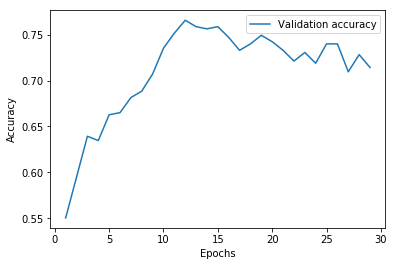

best validatation accu epoch:  12, acc: 0.76581, mean loss: 0.49060 



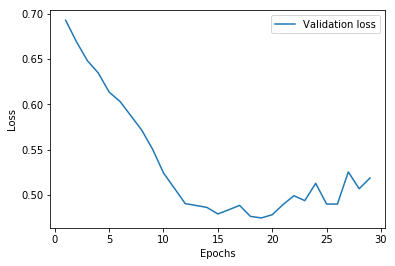

best validatation loss epoch:  19, acc: 0.74941, mean loss: 0.47482


In [15]:
trainLoop(epochs=100, lr=0.000038, wd=1e-6, print_batch_p=0.33, early_patience=10)